# National Drought Analysis

The dataset for this notebook is a weekly time series with measures of the drought conditions in the contiguous United States (CONUS) as a whole. In this notebook, I will inspect the data for trends and build a time series model to forecast future drought conditions. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

np.random.seed(42)

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

In [2]:
drt = pd.read_csv("../capstone_data/data/national_drought_data_combined.csv")

drt.set_index("Date", inplace=True)

drt.index = pd.to_datetime(drt.index)

drt /= 100.0

drt = drt.sort_values("Date")

In [3]:
drt.head()

,None,D0,D1,D2,D3,D4
Date,,,,,,
2000-01-04,0.4900,0.5100,0.2335,0.0945,0.0,0.0
2000-01-11,0.3820,0.6180,0.2493,0.0990,0.0,0.0
2000-01-18,0.3220,0.6780,0.2591,0.1038,0.0,0.0
2000-01-25,0.3074,0.6926,0.2548,0.1011,0.0,0.0
2000-02-01,0.3499,0.6501,0.2897,0.1022,0.0,0.0


I will add a column to include an overall drought measure as a single value for each data point. This will be constructed from taking a weighted sum of the 5 drought level indicators.

In [4]:
drt["D_comp"] = drt["D0"].map(lambda x: 1*x) + \
                drt["D1"].map(lambda x: 1.25*x) + \
                drt["D2"].map(lambda x: 1.5*x) + \
                drt["D3"].map(lambda x: 1.75*x) + \
                drt["D4"].map(lambda x: 2*x)

In [5]:
drt.head()

,None,D0,D1,D2,D3,D4,D_comp
Date,,,,,,,
2000-01-04,0.4900,0.5100,0.2335,0.0945,0.0,0.0,0.943625
2000-01-11,0.3820,0.6180,0.2493,0.0990,0.0,0.0,1.078125
2000-01-18,0.3220,0.6780,0.2591,0.1038,0.0,0.0,1.157575
2000-01-25,0.3074,0.6926,0.2548,0.1011,0.0,0.0,1.162750
2000-02-01,0.3499,0.6501,0.2897,0.1022,0.0,0.0,1.165525


In [6]:
drt.shape

(1009, 7)

I'll inspect the distribution of the new column.

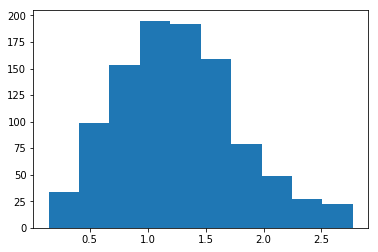

In [7]:
plt.hist(drt["D_comp"]);

In order to make some initial qualitative analysis, I'll plot the time series for each of the drought metrics.

### Overall Drought Score

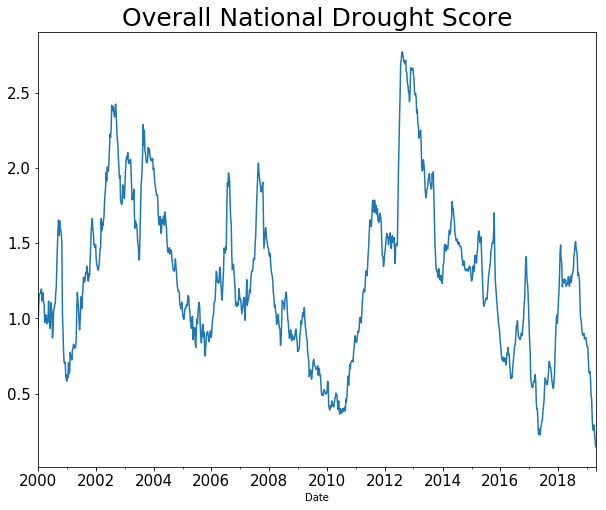

In [8]:
plt.figure(figsize=(10,8))
plt.title("Overall National Drought Score", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D_comp"].plot();

This data shows annual peaks and valleys that reflect seasonality. There were very high levels of drought across the nation in the year 2013 according to this plot. In general, there does not seem to be a noticeable long term trend in the overall drought score. Perhaps that would be reflected if the data spanned a longer time frame.

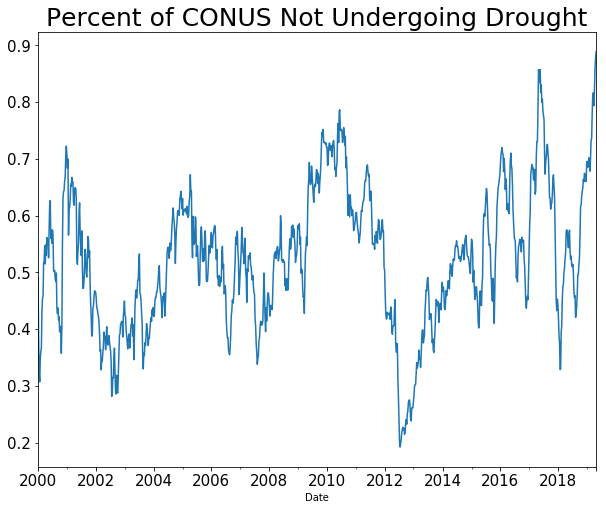

In [9]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Not Undergoing Drought", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["None"].plot();

Again, we can see seasonality and extreme conditions occurring around 2012-2013. It also seems as the the seasonal fluctuations grow somewhat more pronounced in the 2010-2019 range compared to the 2000-2009 range.

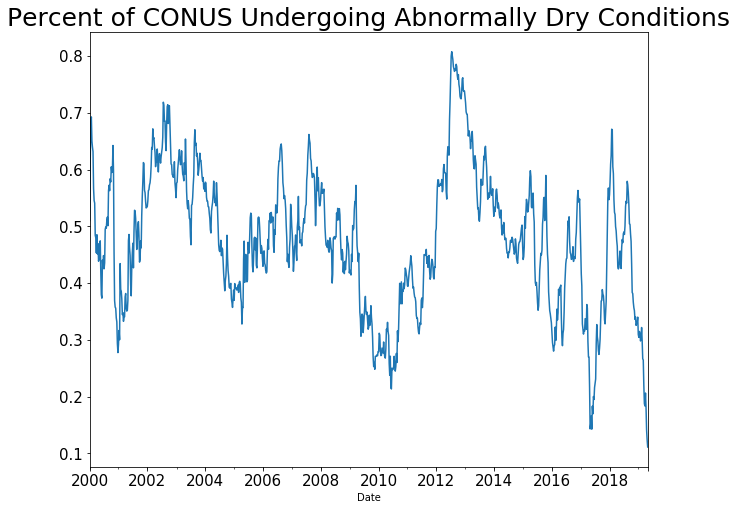

In [10]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Undergoing Abnormally Dry Conditions", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D0"].plot();

We see more of the same with the above plot. The drought conditions fluctuate more violently in the second half of this time series.

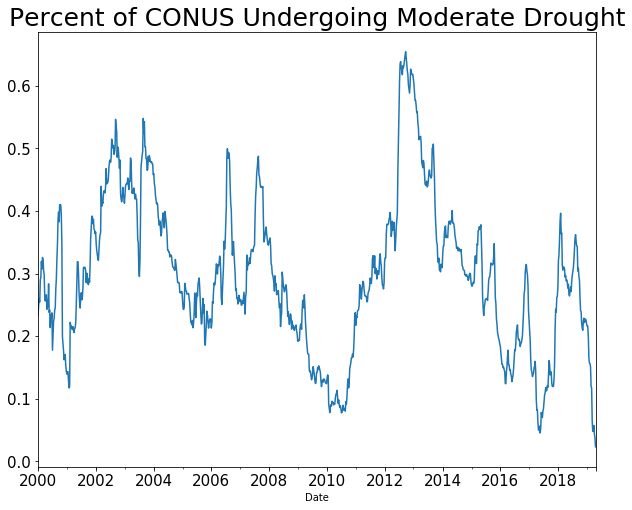

In [11]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Undergoing Moderate Drought", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D1"].plot();

In the above two plots, we can see that there seems to be a seasonal cycle that spans every 4-5 years. We see low points in the drought levels around 2001, 2006, 2011, and 2017. This cycle is disrupted in the most recent years with large yearly fluctuations from 2016 to 2017 to 2018 to 2019.

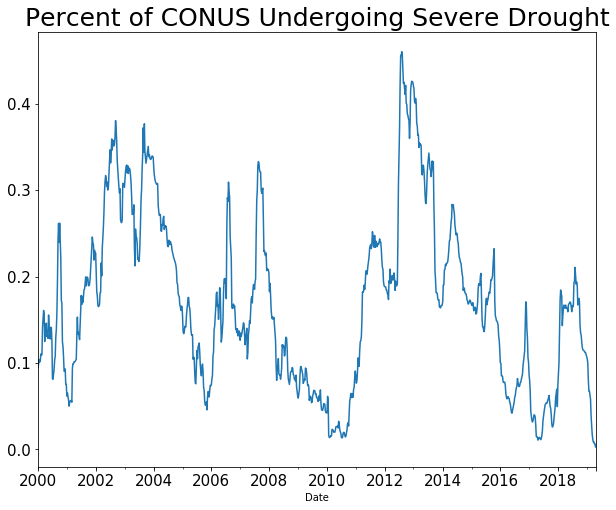

In [12]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Undergoing Severe Drought", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D2"].plot();

Looking at the above plot, it seems that the average level of severe drought is higher starting around 2011 and on. There are extended high levels of severe drought from 2011 to 2016.

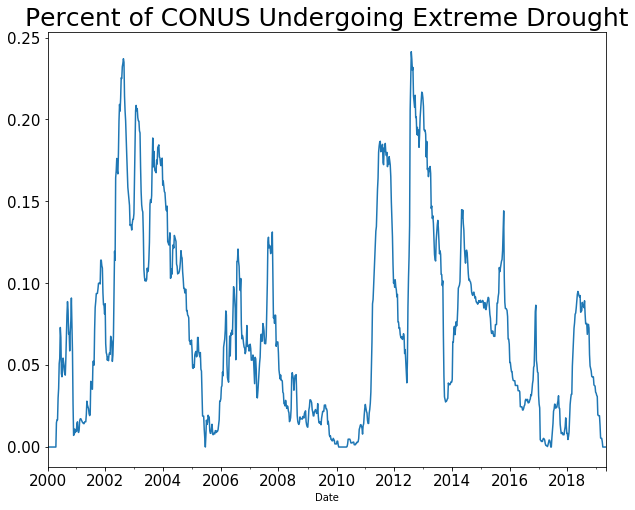

In [13]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Undergoing Extreme Drought", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D3"].plot();

Again, we can see higher average levels and larger yearly fluctuations of extreme drought levels in the later end of the series.

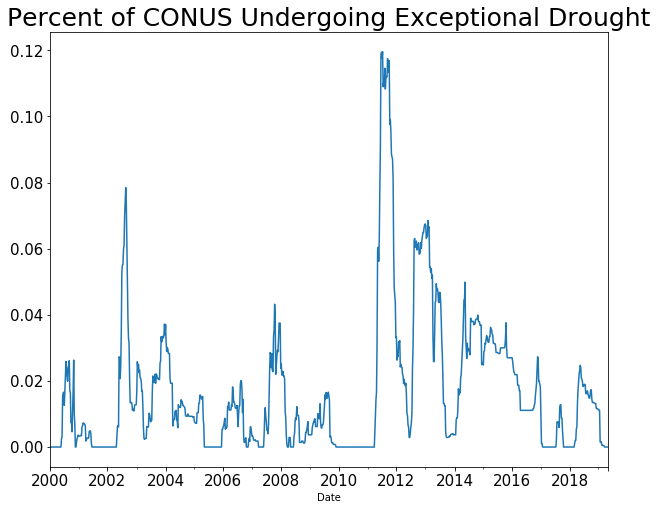

In [14]:
plt.figure(figsize=(10,8))
plt.title("Percent of CONUS Undergoing Exceptional Drought", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
drt["D4"].plot();

This plot shows the most significant changes across time. From 2011 and on, the area under the curve is much larger compared to the beginning of the series. This represents periods of exceptional drought that are much more sustained.

## SARIMA Modeling

I will construct a SARIMA model for the drought conditions in an effort to forecast national drought levels in the future.

In [15]:
# Code written by Joseph Nelson. This is used to perform the augmented Dickey-Fuller test.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

### D_comp

In [16]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D_comp"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D_comp"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D_comp"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 1.4545386156417263e-26.
Differencing our time series by d=1 yields a stationary time series!


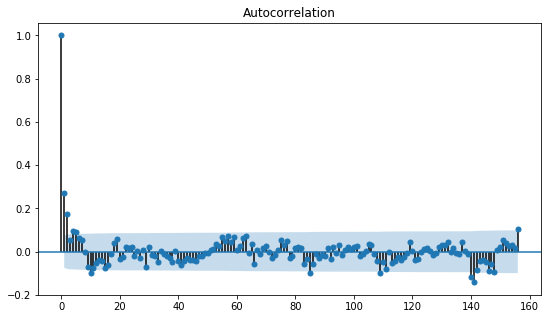

In [17]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D_comp"].diff(1).dropna(), lags=156, ax=ax);

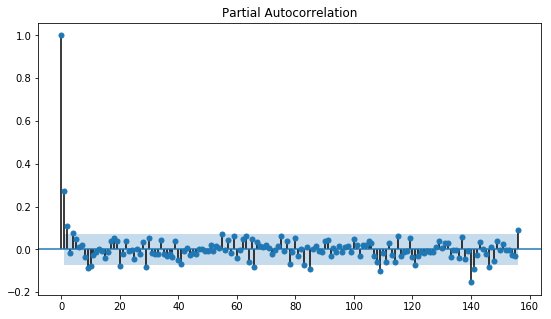

In [18]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D_comp"].diff(1).dropna(), lags=156, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 156 ACF value is above the significance level, so we will set S to 156.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


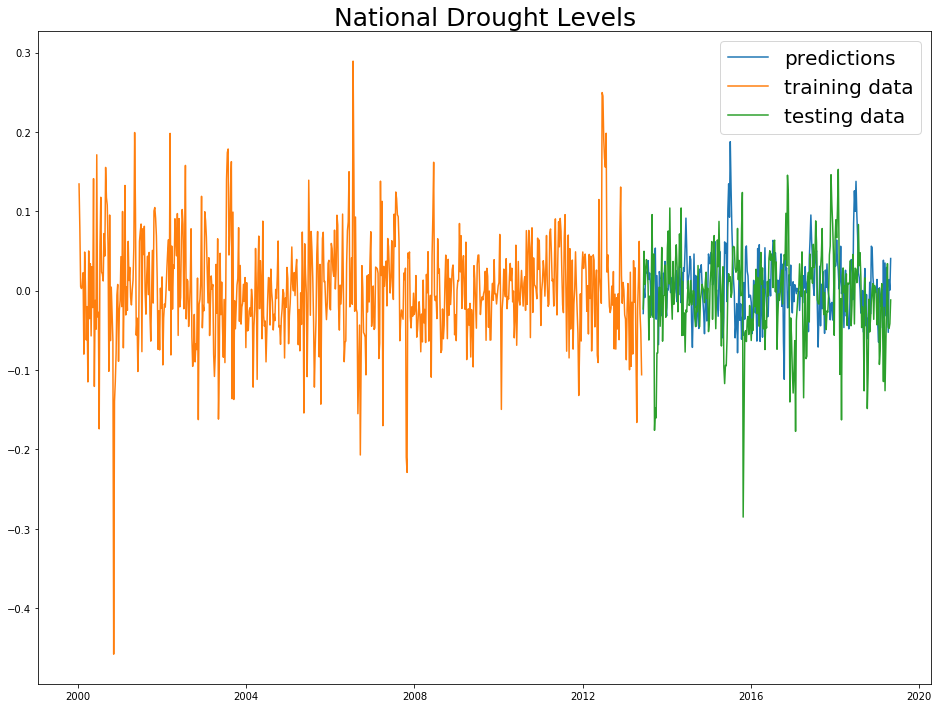

In [19]:
model = SARIMAX(endog = drt[:700]["D_comp"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(2, 1, 0, 156), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D_comp"].diff(1).dropna()
test = drt[700:]["D_comp"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Drought Levels", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
mean_absolute_error(test, y_hat)

0.05331385517523329

In [22]:
mean_squared_error(test, y_hat)

0.004795528758900541

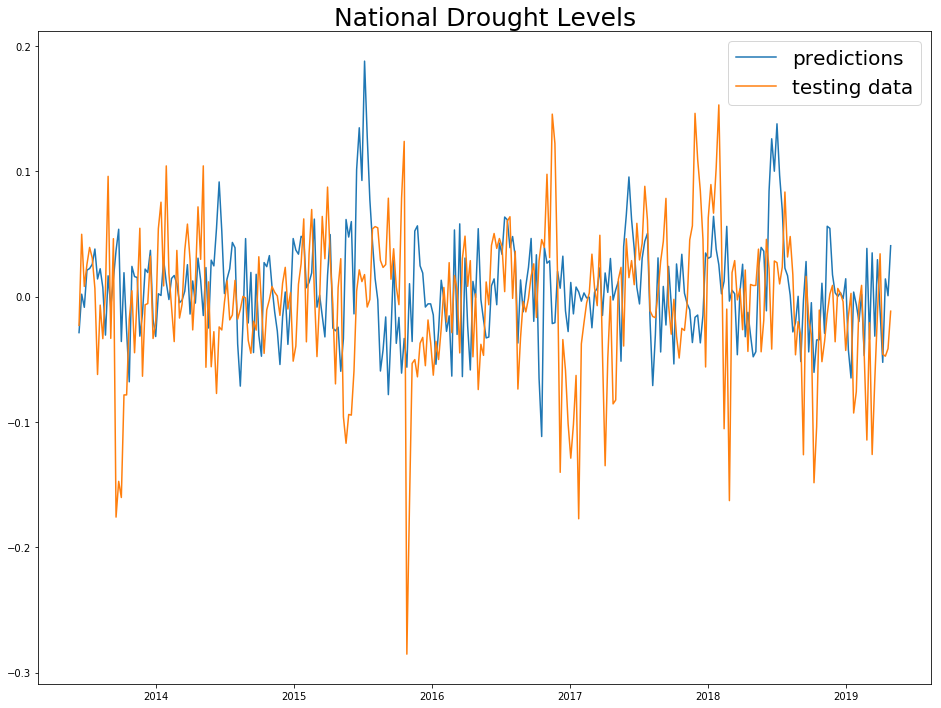

In [23]:
plt.figure(figsize=(16,12)) 
plt.title("National Drought Levels", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

The model seems to be performing decently well in terms of predicting the broad seasonality and the long term trend. It is not a good predictor of the short term fluctuations.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


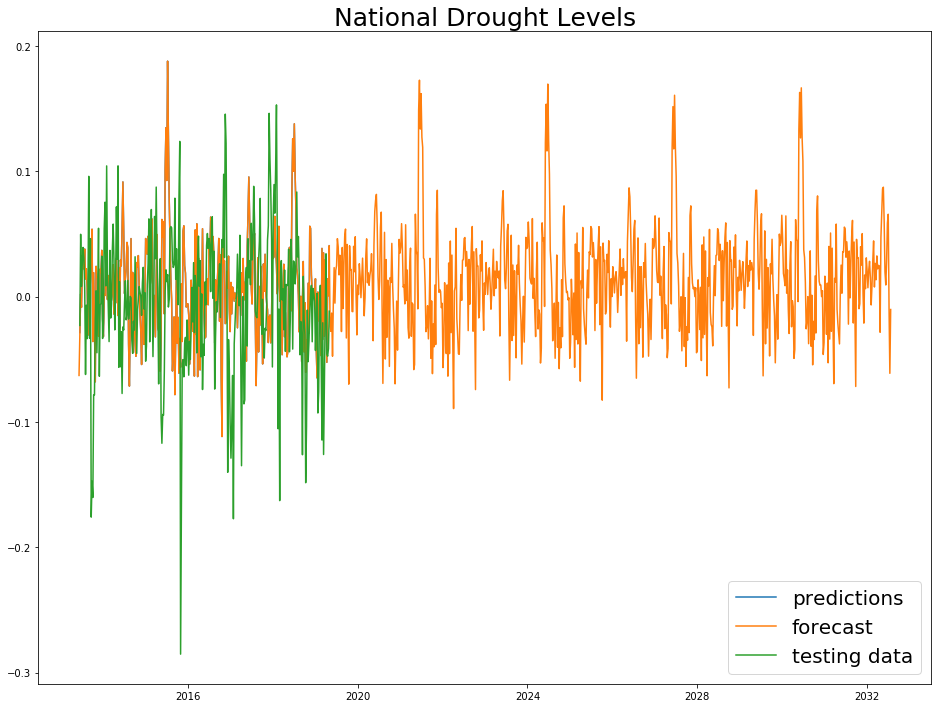

In [24]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Drought Levels", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### None: Not Undergoing Drought

In [25]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["None"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["None"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["None"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 0.0.
Differencing our time series by d=1 yields a stationary time series!


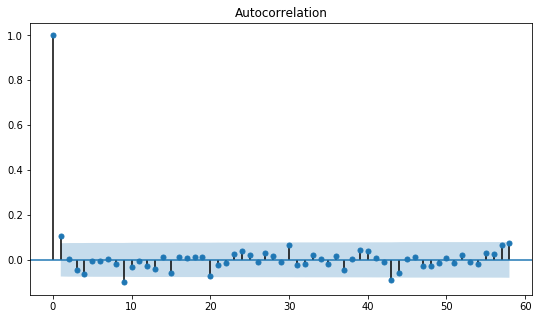

In [26]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["None"].diff(1).dropna(), lags=58, ax=ax);

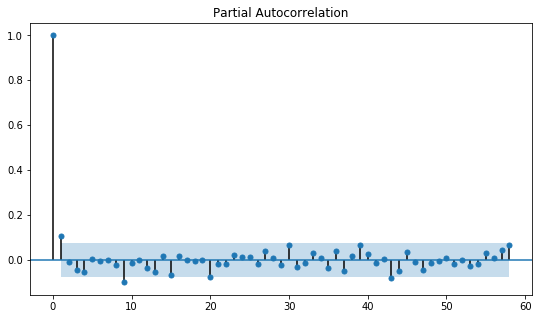

In [27]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["None"].diff(1).dropna(), lags=58, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 58 value is the highest value beyond lag 1, so we will set S to 58.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


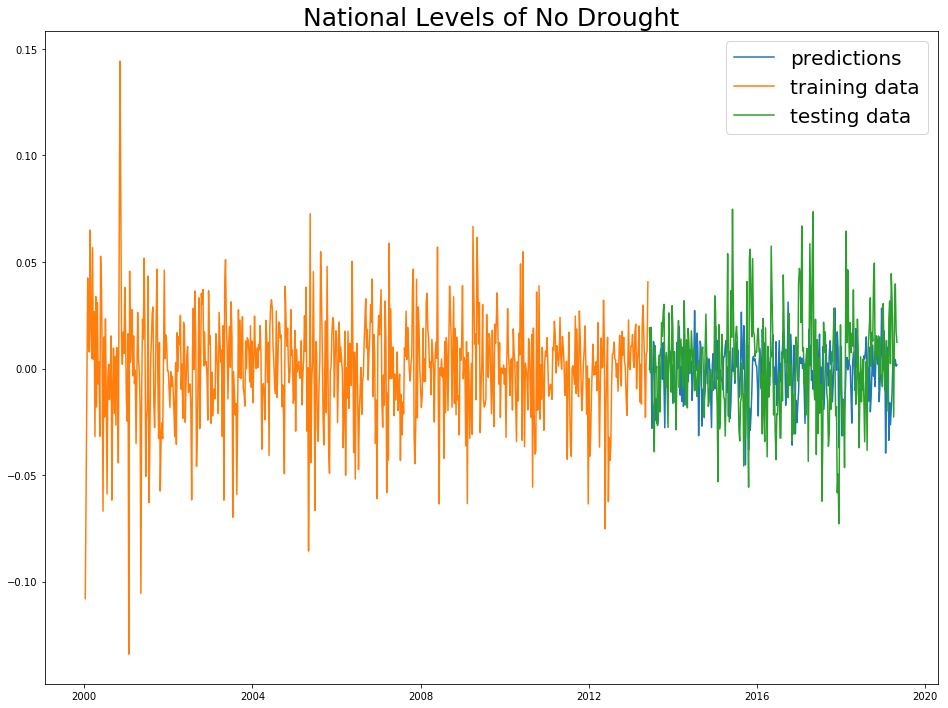

In [28]:
model = SARIMAX(endog = drt[:700]["None"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(2, 1, 0, 58), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["None"].diff(1).dropna()
test = drt[700:]["None"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of No Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [29]:
mean_absolute_error(test, y_hat)

0.021227947896333872

In [30]:
mean_squared_error(test, y_hat)

0.0007137542049344017

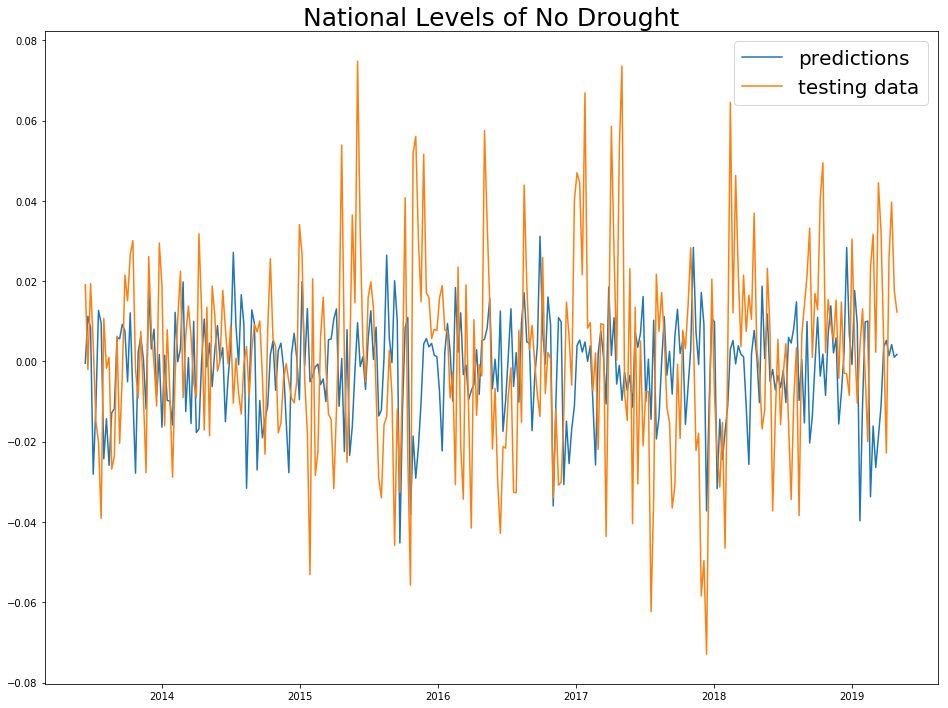

In [31]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of No Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

The model seems to be performing decently well in terms of predicting the broad seasonality and the long term trend. It is not a good predictor of the short term fluctuations.

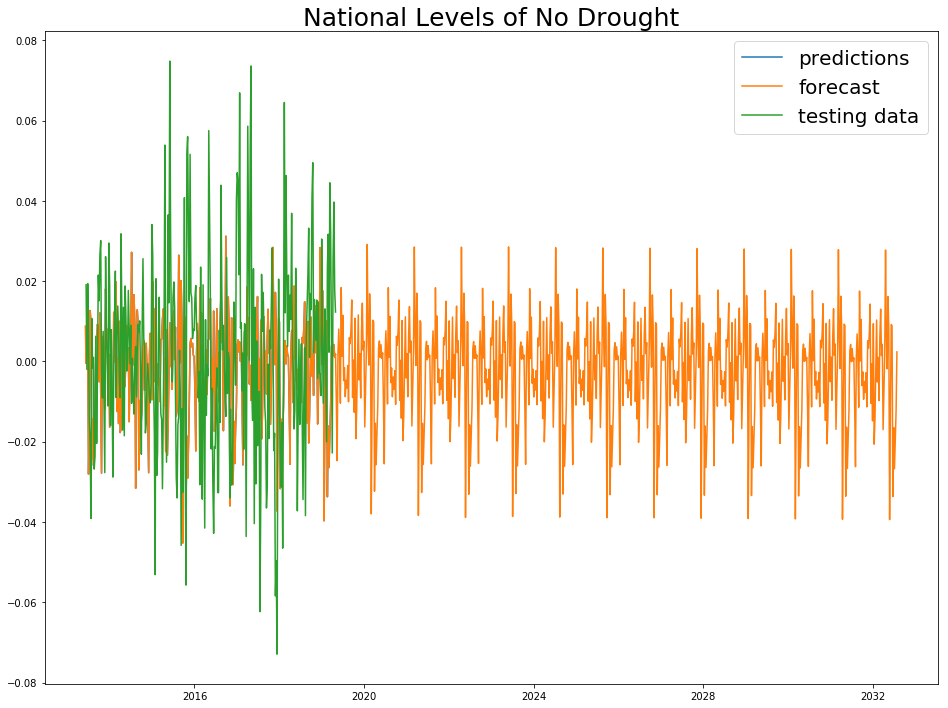

In [33]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of No Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### D0: Abnormally Dry Conditions

In [34]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D0"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D0"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D0"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 0.0.
Differencing our time series by d=1 yields a stationary time series!


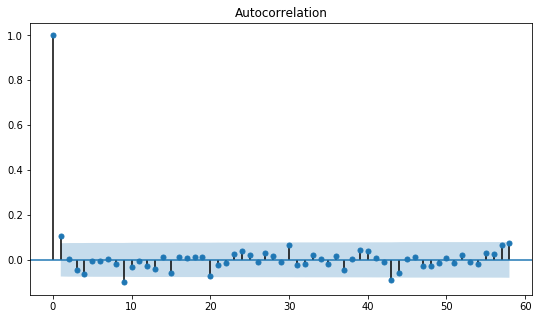

In [35]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D0"].diff(1).dropna(), lags=58, ax=ax);

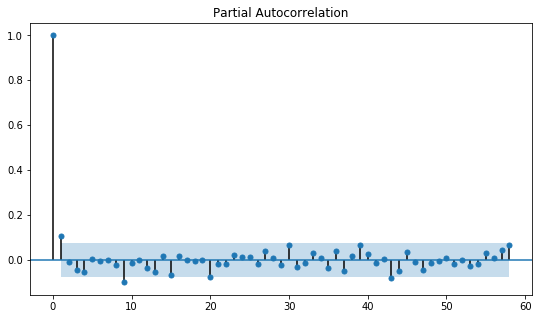

In [36]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D0"].diff(1).dropna(), lags=58, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 58 value is the highest beyond lag 1, so we will set S to 58.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


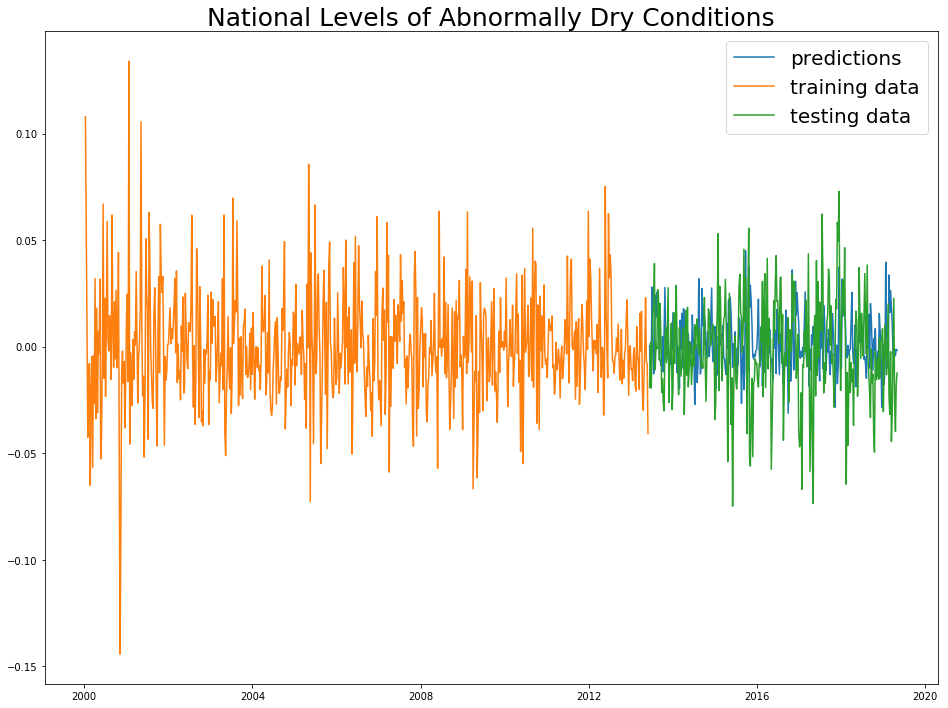

In [37]:
model = SARIMAX(endog = drt[:700]["D0"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(2, 1, 0, 58), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D0"].diff(1).dropna()
test = drt[700:]["D0"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Abnormally Dry Conditions", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [38]:
mean_absolute_error(test, y_hat)

0.02122709920200125

In [39]:
mean_squared_error(test, y_hat)

0.000713597959079671

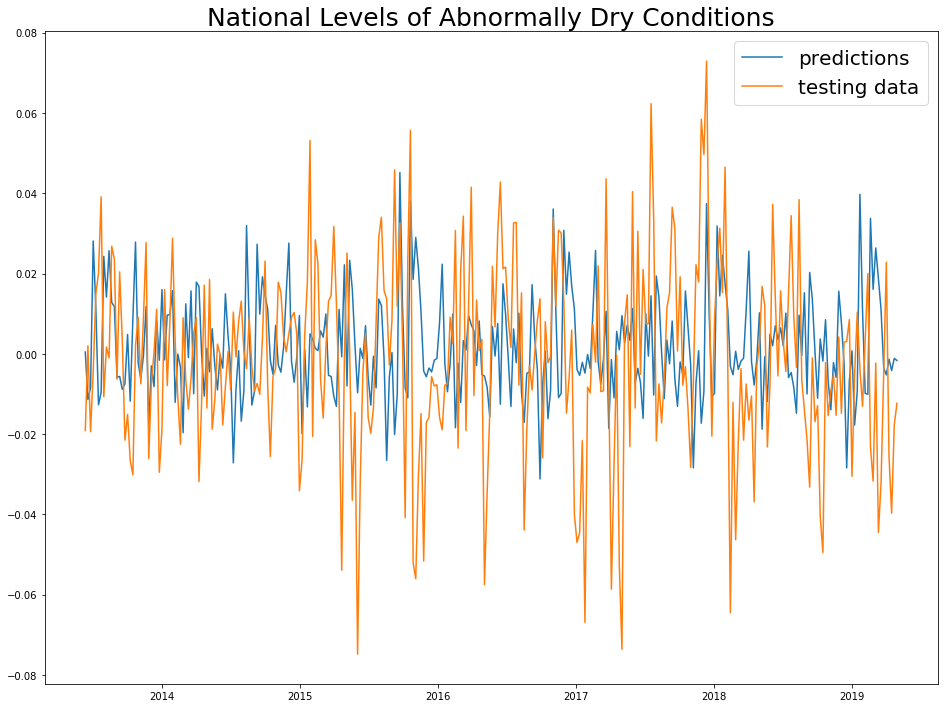

In [40]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Abnormally Dry Conditions", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

The model seems to be performing decently well in terms of predicting the broad seasonality and the long term trend. It is not a good predictor of the short term fluctuations.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


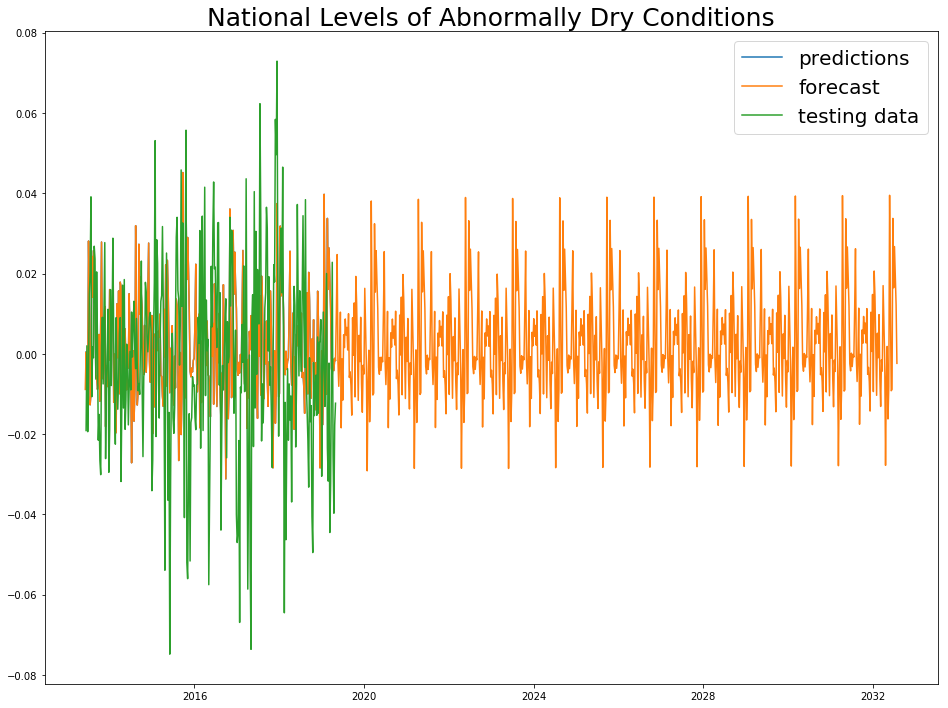

In [41]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of Abnormally Dry Conditions", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### D1: Moderate Drought

In [42]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D1"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D1"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D1"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 1.9912223850792527e-27.
Differencing our time series by d=1 yields a stationary time series!


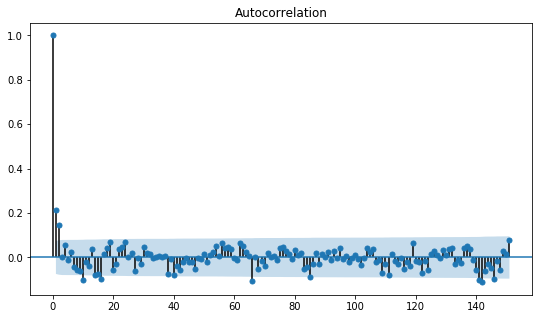

In [43]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D1"].diff(1).dropna(), lags=151, ax=ax);

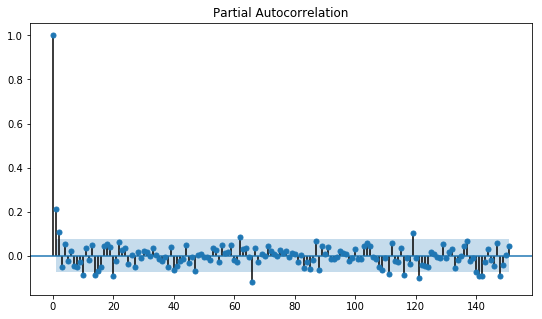

In [44]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D1"].diff(1).dropna(), lags=151, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 151 value is the highest beyond the early lags, so we will set S to 151.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


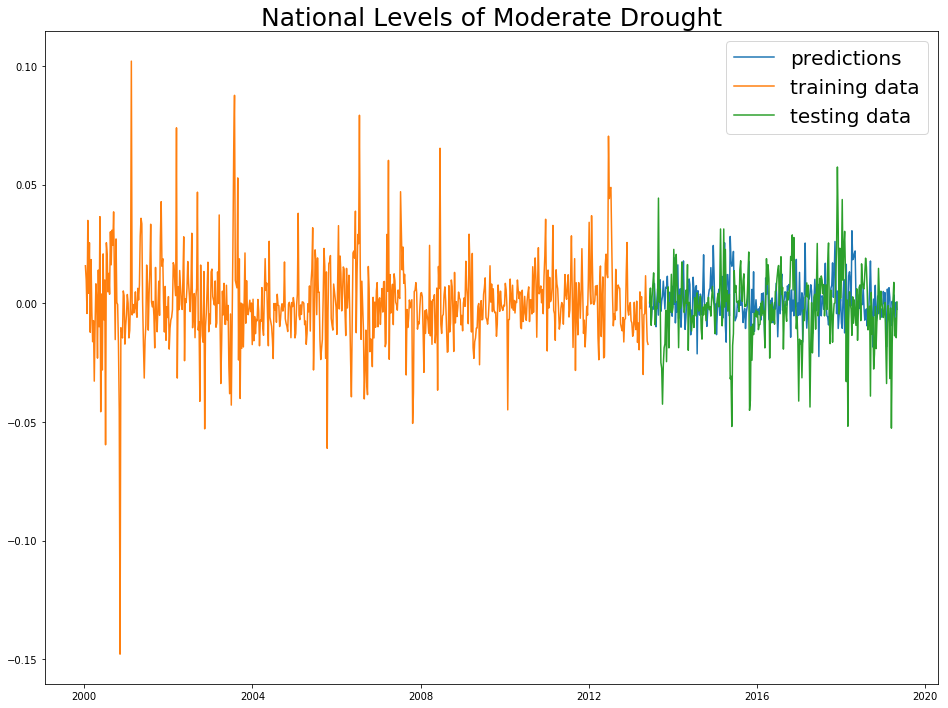

In [45]:
model = SARIMAX(endog = drt[:700]["D1"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(2, 1, 0, 151), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D1"].diff(1).dropna()
test = drt[700:]["D1"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Moderate Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [49]:
mean_absolute_error(test, y_hat)

0.012966955408883998

In [50]:
mean_squared_error(test, y_hat)

0.0003189454017076427

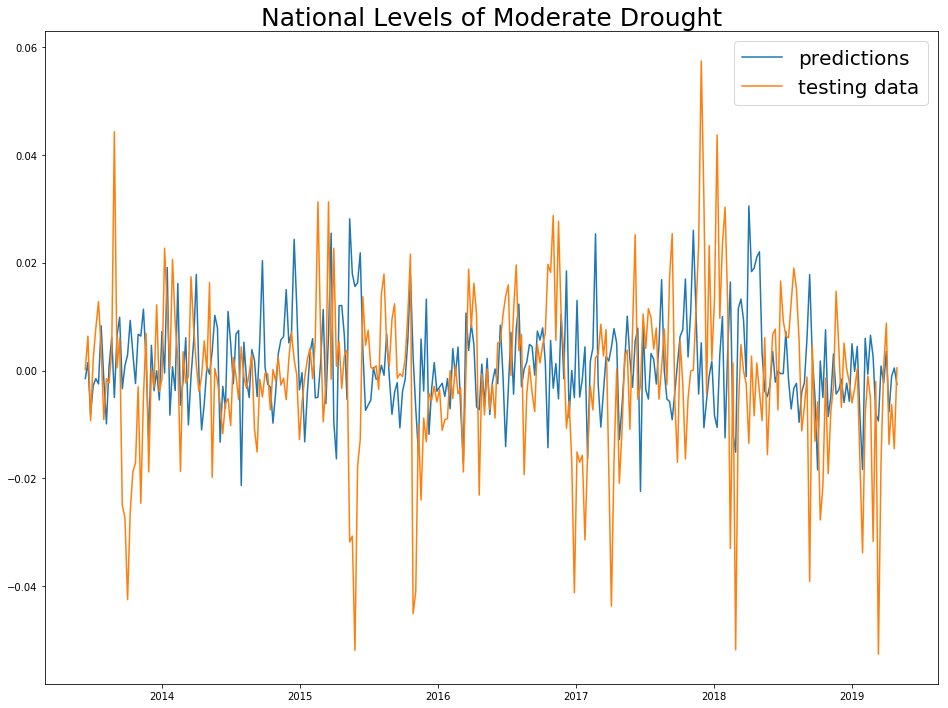

In [51]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Moderate Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

The model seems to be performing decently well in terms of predicting the broad seasonality and the long term trend. It is not a good predictor of the short term fluctuations.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


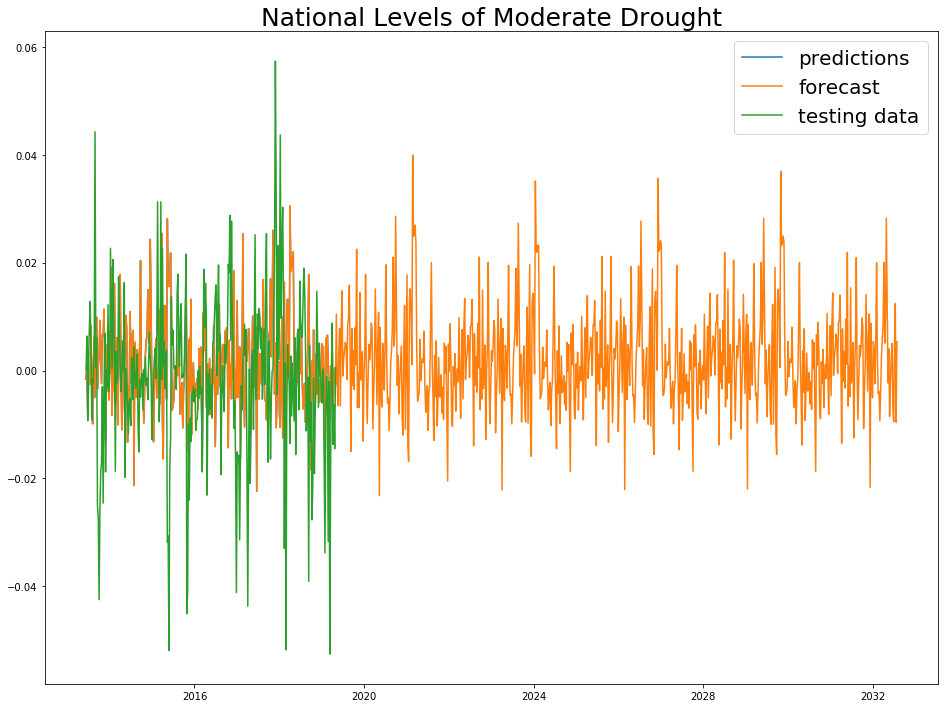

In [52]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of Moderate Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### D2: Severe Drought

In [53]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D2"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D2"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D2"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 2.259853329850788e-26.
Differencing our time series by d=1 yields a stationary time series!


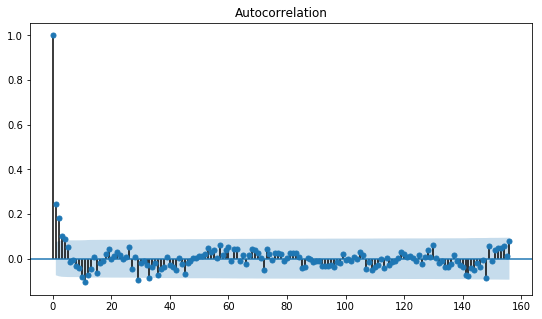

In [54]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D2"].diff(1).dropna(), lags=156, ax=ax);

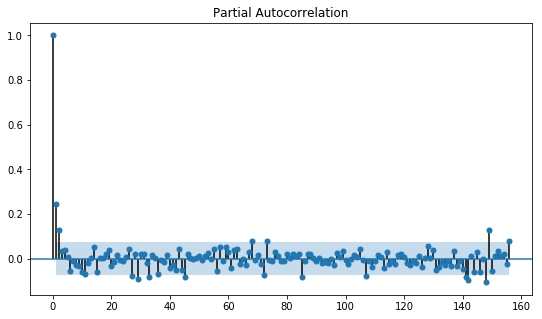

In [55]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D2"].diff(1).dropna(), lags=156, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 156 value is the highest beyond the early lags, so we will set S to 156.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


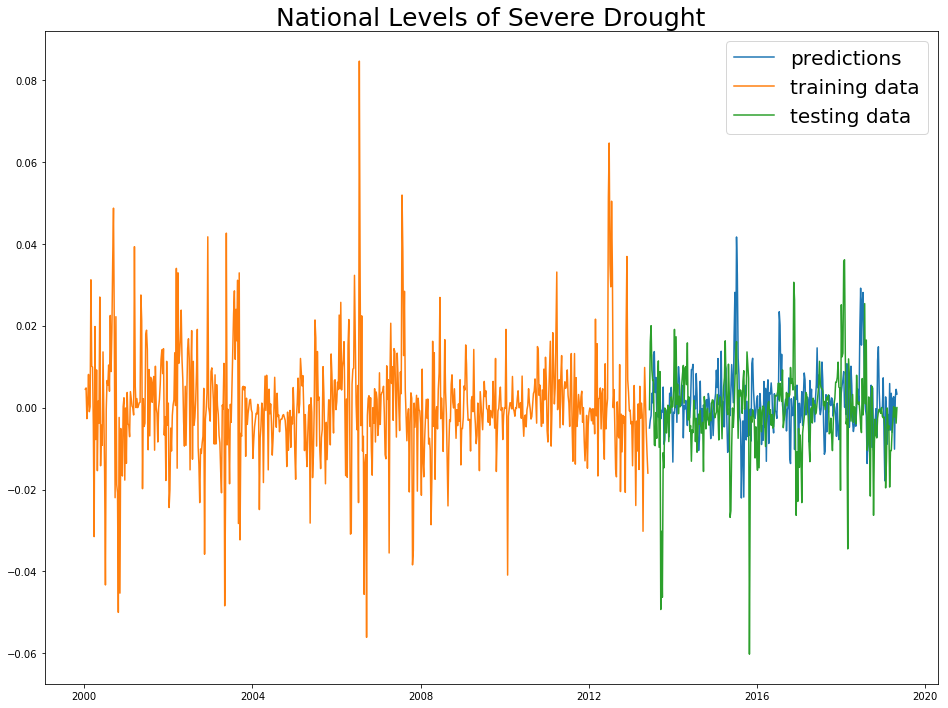

In [56]:
model = SARIMAX(endog = drt[:700]["D2"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(2, 1, 0, 156), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D2"].diff(1).dropna()
test = drt[700:]["D2"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Severe Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [57]:
mean_absolute_error(test, y_hat)

0.009062811164862426

In [58]:
mean_squared_error(test, y_hat)

0.00015592907321825111

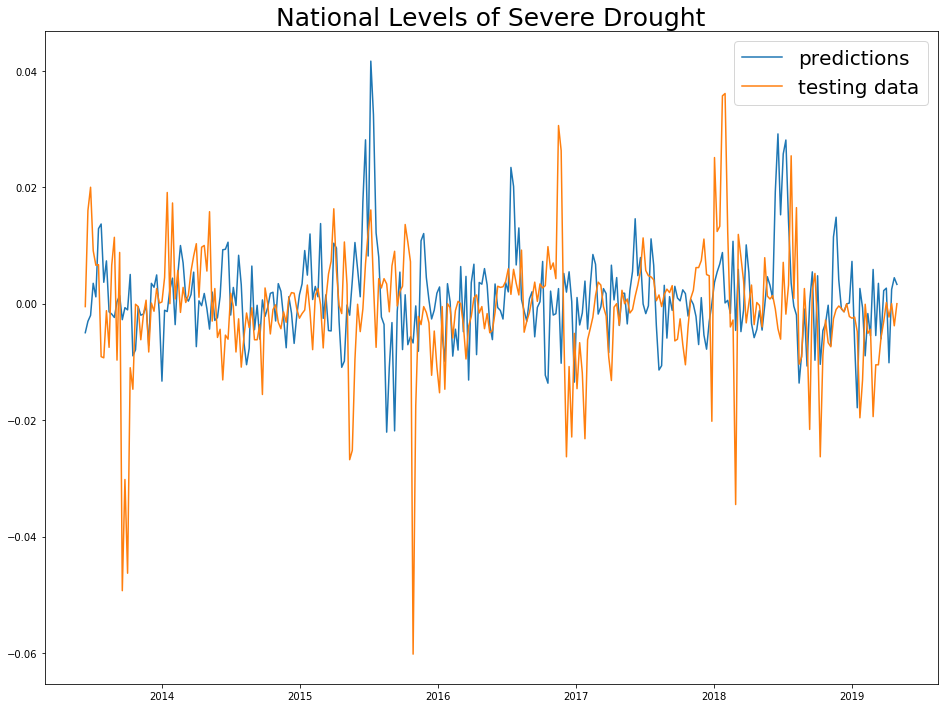

In [59]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Severe Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

The model seems to be performing well in terms of predicting the broad seasonality and the long term trend. It is not a good predictor of the short term fluctuations.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


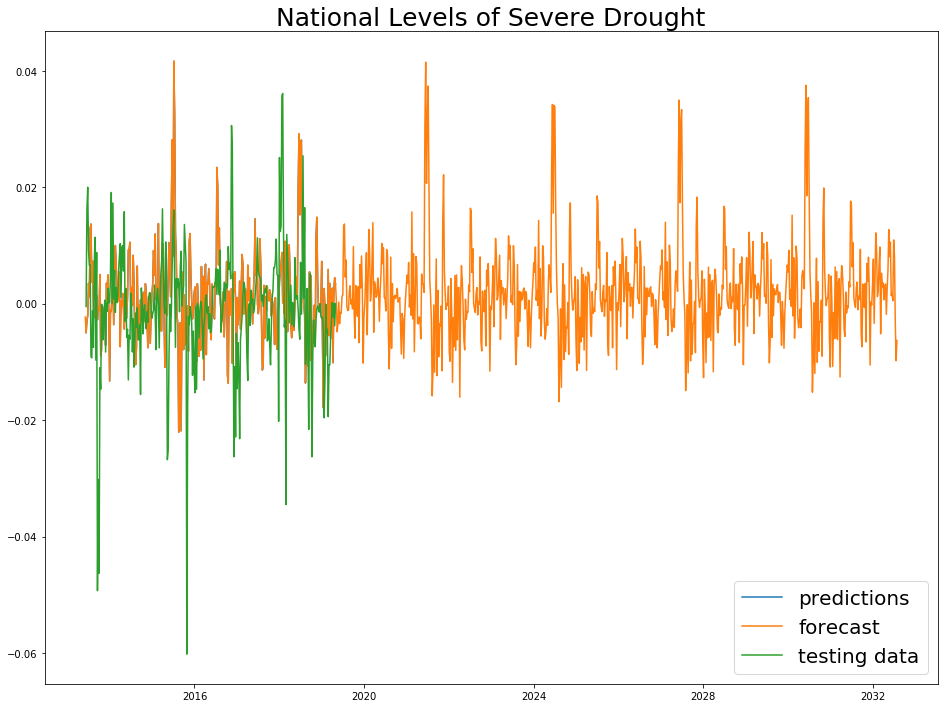

In [60]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of Severe Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### D3: Extreme Drought

In [61]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D3"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D3"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D3"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 8.791333977179268e-15.
Differencing our time series by d=1 yields a stationary time series!


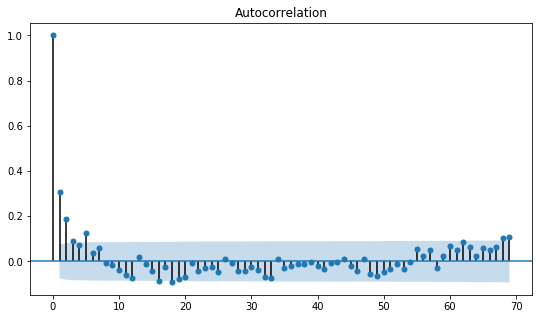

In [62]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D3"].diff(1).dropna(), lags=69, ax=ax);

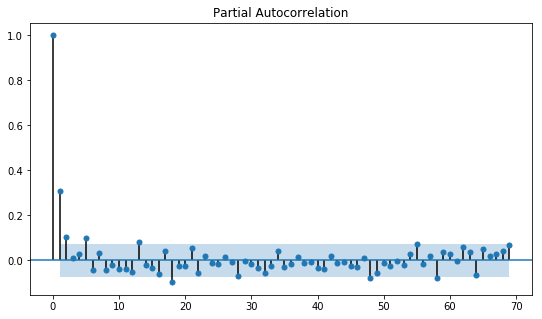

In [63]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D3"].diff(1).dropna(), lags=69, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 69 value is the highest beyond the early lags, so we will set S to 69.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


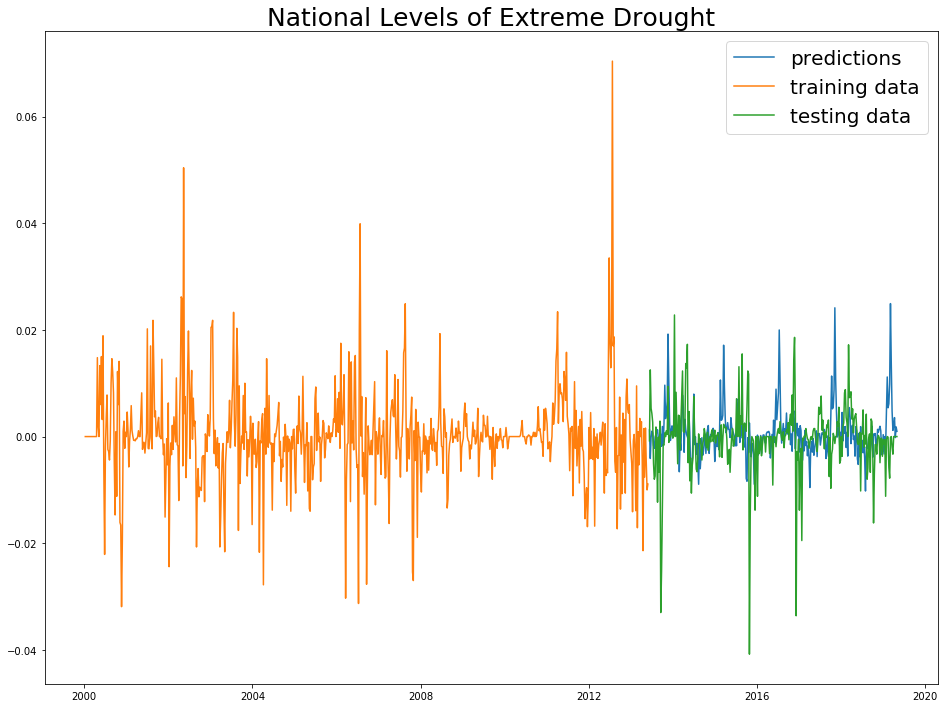

In [64]:
model = SARIMAX(endog = drt[:700]["D3"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(5, 1, 0, 69), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D3"].diff(1).dropna()
test = drt[700:]["D3"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Extreme Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [65]:
mean_absolute_error(test, y_hat)

0.00483890916574551

In [66]:
mean_squared_error(test, y_hat)

5.489846676733334e-05

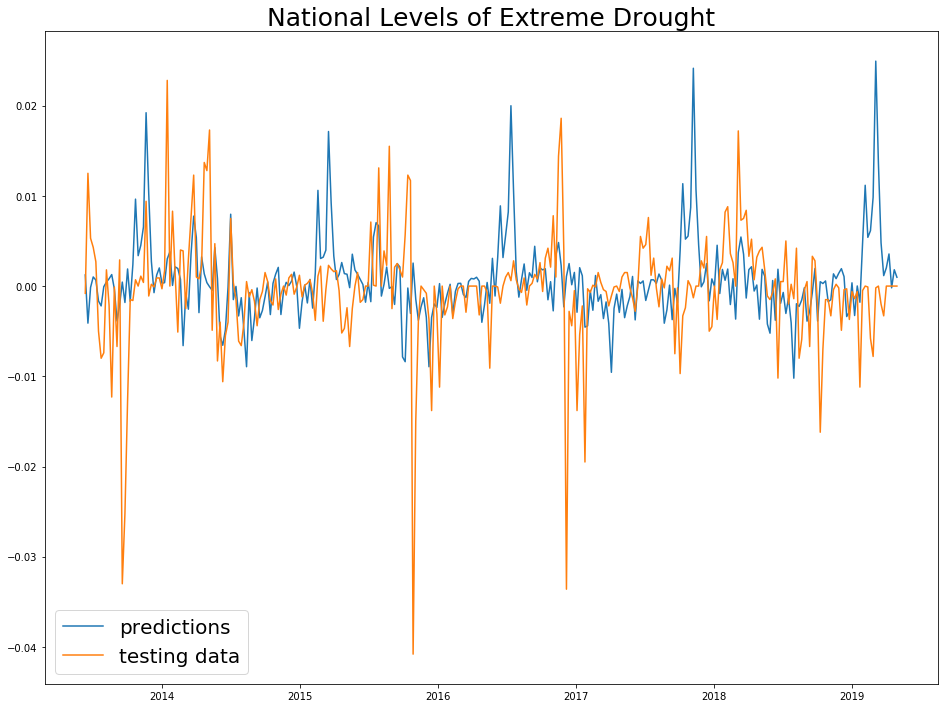

In [67]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Extreme Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

This model seems to be misreading the seasonality. It's possible that it would be better to select a different value for S.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


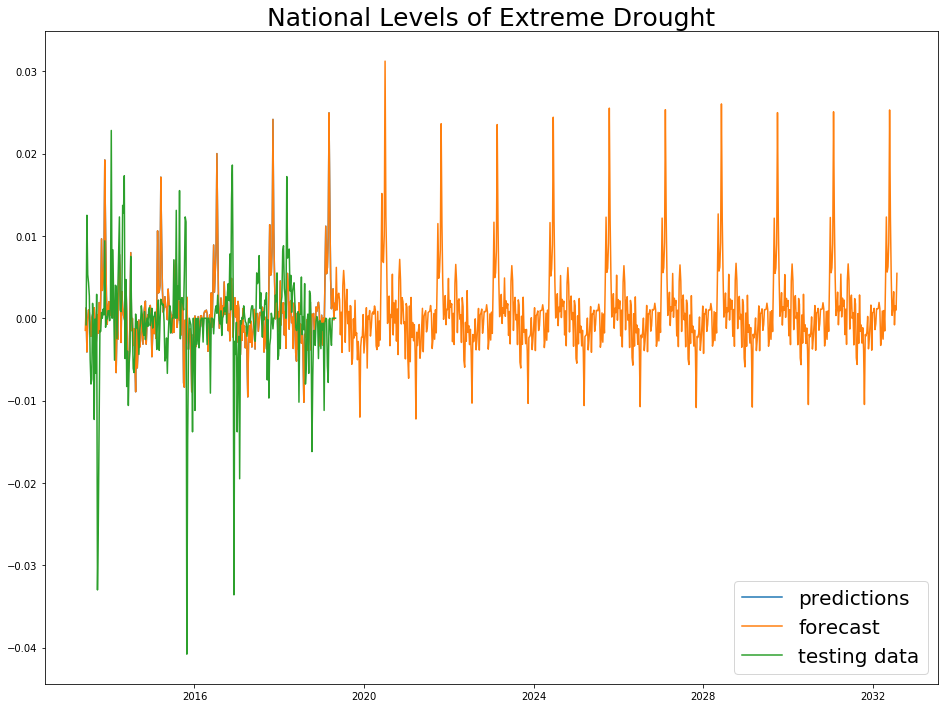

In [68]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of Extreme Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

### D4: Exceptional Drought

In [69]:
# Iterate through all possible differences.
for d in range(1, len(drt[:700]["D4"])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(drt[:700]["D4"].diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(drt[:700]["D4"].diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
        break
    
    print()

Checking difference of 1.
p-value = 4.12517031161978e-12.
Differencing our time series by d=1 yields a stationary time series!


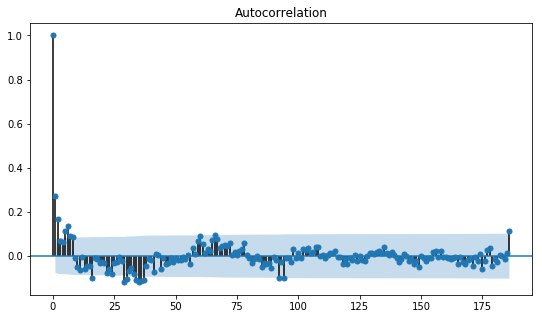

In [70]:
fig, ax = plt.subplots(figsize=(9,5))

plot_acf(drt[:700]["D4"].diff(1).dropna(), lags=186, ax=ax);

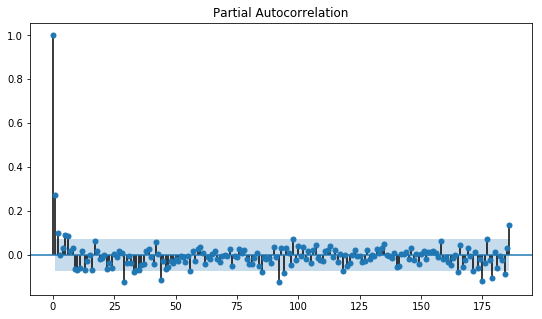

In [71]:
fig, ax = plt.subplots(figsize=(9,5))

plot_pacf(drt[:700]["D4"].diff(1).dropna(), lags=186, ax=ax);

- Based on the ADF test, d = 1.
- The first lag of the ACF is above the positive significance level, so we will set q to 1.
- The first lag of the PACF is above the positive significance level, so we will set p to 1.
- The lag 186 value is the highest beyond the early lags, so we will set S to 186.
- The ACF is positive at lag S, so P >= 1 and Q = 0.
- The seasonal pattern is fairly stable over time, so we will set D = 1.

I'll build a function that can perform the modeling for a given column.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  % freq, ValueWarning)


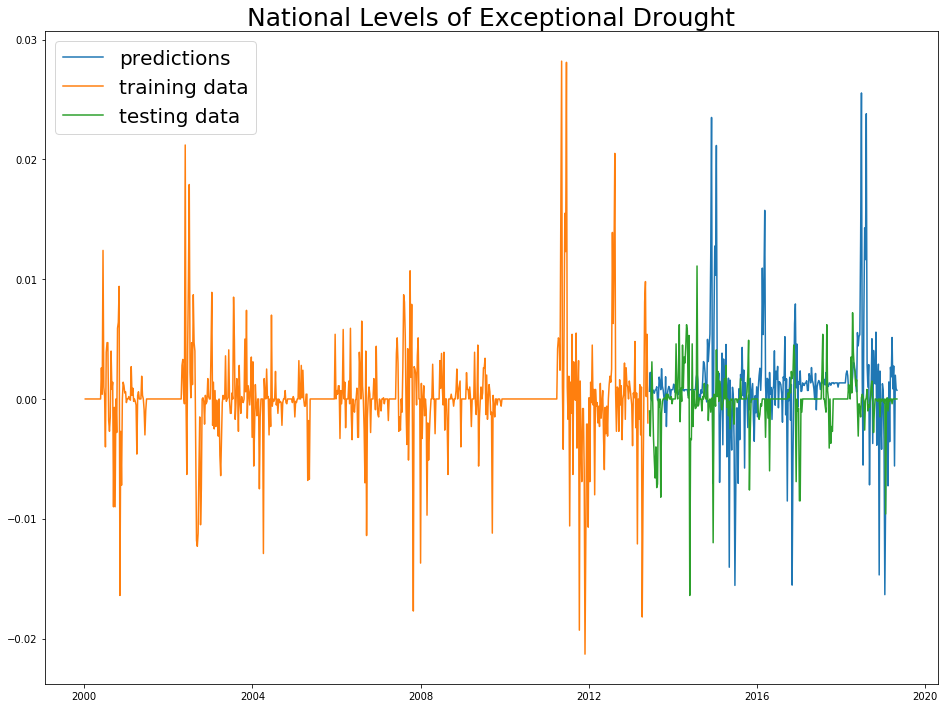

In [78]:
model = SARIMAX(endog = drt[:700]["D4"].diff(1).dropna(), # endog = Y variable
                  order = (1,1,1), seasonal_order=(1, 1, 0, 186), enforce_invertibility=False)
              
model_fit = model.fit()
train = drt[:700]["D4"].diff(1).dropna()
test = drt[700:]["D4"].diff(1).dropna()
start = test.index[0]
end = test.index[-1]
y_hat = model_fit.predict(start=start, end=end)
              
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Exceptional Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(train, label="training data");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

In [79]:
mean_absolute_error(test, y_hat)

0.0032862697614065607

In [80]:
mean_squared_error(test, y_hat)

2.6689555378608928e-05

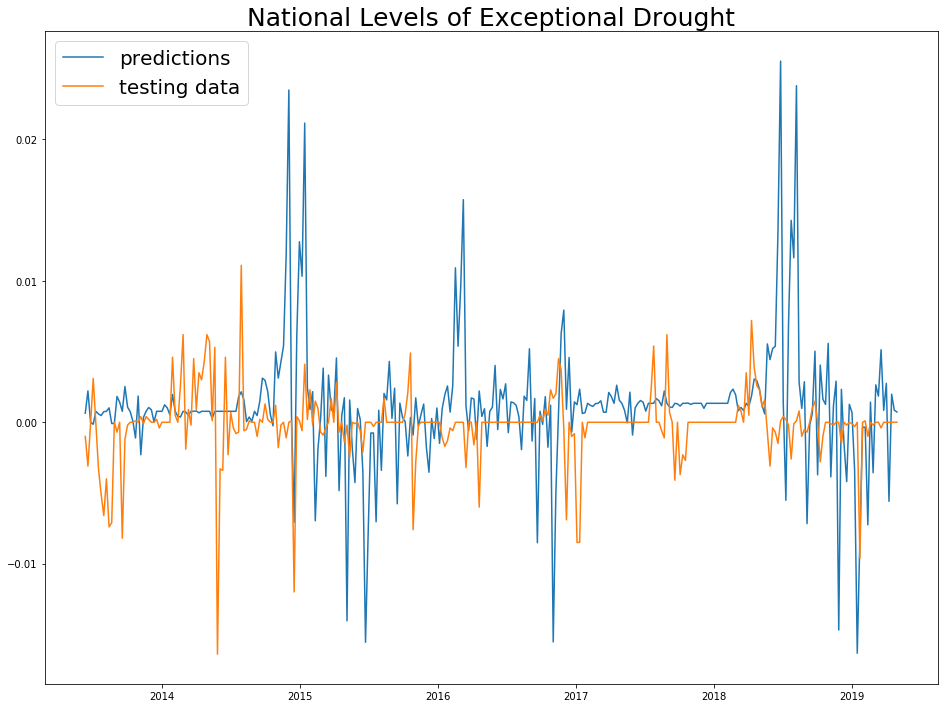

In [81]:
plt.figure(figsize=(16,12)) 
plt.title("National Levels of Exceptional Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);

This model is not very good. It attempts to predict short term fluctuations, but it is not lined up with the actual data. The predicted sudden spikes are a much larger magnitude than is reflected in the actual data.

/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


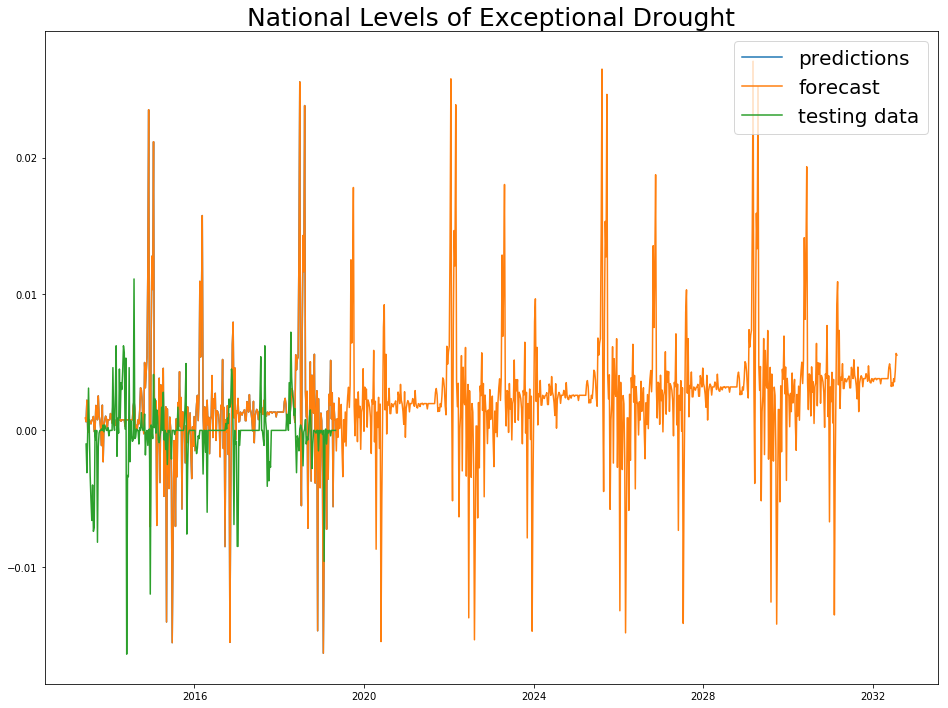

In [82]:
forecast = model_fit.forecast(steps=1000)

plt.figure(figsize=(16,12)) 
plt.title("National Levels of Exceptional Drought", fontsize=25)
plt.plot(y_hat, label="predictions");
plt.plot(forecast, label="forecast");
plt.plot(test, label = "testing data");
plt.legend(fontsize=20);